In [1]:
import numpy as np
from skimage.measure import label, regionprops
from skimage.morphology import binary_erosion, disk
from skimage.segmentation import clear_border
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
from scipy.ndimage import binary_fill_holes
from skimage.transform import resize

import nibabel as nib
import os
import matplotlib.pyplot as plt

In [49]:
def get_crop_coords_mri_patient_single(path_to_image: str, path_to_label: str, vol_size = [128, 128, 128]): 
    '''
    Takes the path to an MRI image and its corresponding label, and computes the coordinetes of the original 3D volume
    after cropping it to vol_size.
    This should be a direct preprocessing step in a training pipeline.
    The coordinates for the cropped volume and corresponding label are centered in the original volume and shifted up 20 pixels.
    
    Parameters:
    path_to_image (str): The path to the MRI image.
    path_to_label (str): The path to the corresponding label. Binary mask.
    vol_size (list): The size of the cropped volume. Default is [60, 80, 80].

    returns:
    coords (list): The coordinates of the cropped volume in the original volume.
    
    '''
    print(path_to_image, path_to_label)
    # Load the image and label
    img = nib.load(path_to_image)
    label = nib.load(path_to_label)

    # Get the data
    img_data = img.get_fdata()
    label_data = label.get_fdata()

    # From the centre of the entire volume, crop the volume to vol_size
    x, y, z = img_data.shape
    xx, yy, zz = label_data.shape

    # Check if the image and label have the same size
    if x != xx or y != yy or z != zz:
        raise ValueError('The image and label do not have the same size.')

    # Compute the coordinates for the cropped volume and shift it up in the x-direction
    x_start = int(x/2 - vol_size[0]/2) 
    x_end = int(x/2 + vol_size[0]/2) 
    y_start = int(y/2 - vol_size[1]/2) 
    y_end = int(y/2 + vol_size[1]/2) 
    z_start = int(z/2 - vol_size[2]/2) + 32
    z_end = int(z/2 + vol_size[2]/2) + 32

    # return the coordinates of the cropped volume in the original volume
    coords = [x_start, x_end, y_start, y_end, z_start, z_end]

    return coords

    

def crop_mri_patient_multiple(subject_folder: str, img_name:str = 'co_FLAIR.nii', label_name:str = 'mask.nii', vol_size = [128, 128, 128]):
    '''
    Calls fun crop_mri_patient_single for all MRI images in a folder.

    For each MRI image in the folder, the function computes the coordinates of the original 3D volume
      (where the MRI image is) after cropping it to vol_size.


    Parameters:
    subject_folder (str): The path to the folder containing the MRI images.
    '''

    coords_list = []
    subjects = os.listdir(subject_folder)
    if '.DS_Store' in subjects:
        subjects.remove('.DS_Store')
    
    for subject in subjects:
        path_to_image = os.path.join(subject_folder, subject, img_name)
        path_to_label = os.path.join(subject_folder, subject, label_name)
        coords = get_crop_coords_mri_patient_single(path_to_image, path_to_label, vol_size = vol_size)
        coords_list.append(coords)
    
    return coords_list


def load_img_and_label_crop_and_display(subject_folder:str, 
                                        img_name:str = 'co_FLAIR.nii', label_name:str = 'mask.nii', 
                                        vol_size= [128, 128, 128], 
                                        save_crop = False):
    '''
    Loads the MRI image and label, crops them to vol_size and displays them.
    The function is used to check if the cropping is done correctly.

    Parameters:
    subject_folder (str): The path to the folder containing the MRI images.
    vol_size (list): The size of the cropped volume. Default is [60, 80, 80].
    '''

    coords_list = crop_mri_patient_multiple(subject_folder, img_name, label_name, vol_size)
    subjects = os.listdir(subject_folder)
    # for each subject, cut out a part and display one slice. 
    # The plot should contain a slice of each subject and its corresponding label.

    if '.DS_Store' in subjects:
        subjects.remove('.DS_Store')

    for i, subject in enumerate(subjects):
        # Load the image and label
        path_to_image = os.path.join(subject_folder, subject, img_name)
        path_to_label = os.path.join(subject_folder, subject, label_name)
        print(path_to_image, path_to_label)
        img = nib.load(path_to_image)
        label = nib.load(path_to_label)
        img_data = img.get_fdata()
        label_data = label.get_fdata()
        coords = coords_list[i]
        # Crop the image and label
        img_data = img_data[coords[0]:coords[1], coords[2]:coords[3], coords[4]:coords[5]]
        label_data = label_data[coords[0]:coords[1], coords[2]:coords[3], coords[4]:coords[5]]
        # Save the cropped image and label
        img = nib.Nifti1Image(img_data, img.affine)
        label = nib.Nifti1Image(label_data, label.affine)
        if save_crop:
            nib.save(img, os.path.join(subject_folder, subject, 'cropped_' + img_name))
            nib.save(label, os.path.join(subject_folder, subject, 'cropped_' + label_name))

        # Display the image and label
        _, ax = plt.subplots(1, 2, figsize=(6, 3))
        ax[0].imshow(img_data[:,:,55], cmap='gray')
        ax[0].set_title('MRI Image')
        ax[0].axis('off')
        ax[1].imshow(label_data[:,:,55], cmap='gray')
        ax[1].set_title('Label')
        ax[1].axis('off')
        plt.show()
        
    return

    

    

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/18/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/18/mask.nii
/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/9/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/9/mask.nii
/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/0/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/0/mask.nii
/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/11/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/11/mask.nii
/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAI

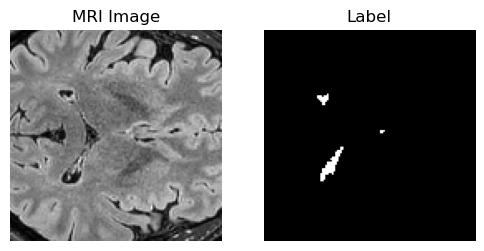

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/9/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/9/mask.nii


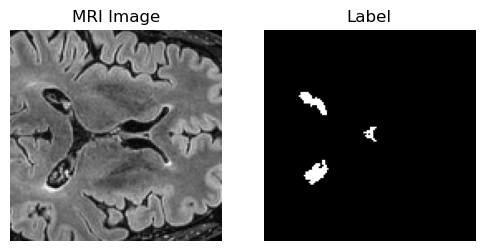

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/0/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/0/mask.nii


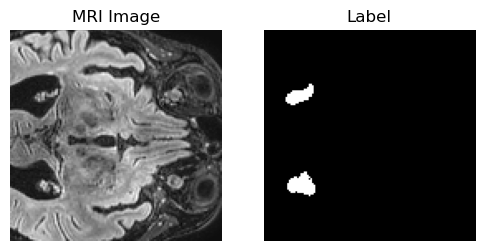

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/11/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/11/mask.nii


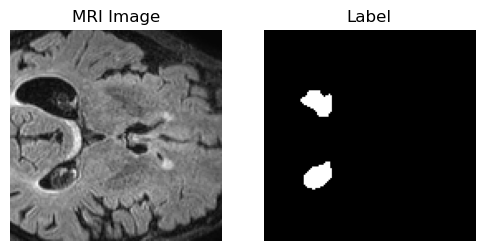

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/7/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/7/mask.nii


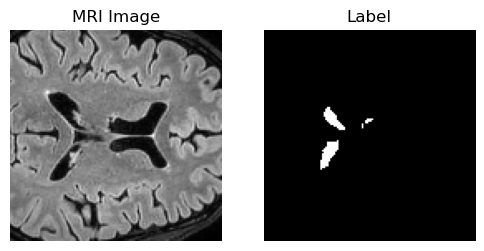

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/16/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/16/mask.nii


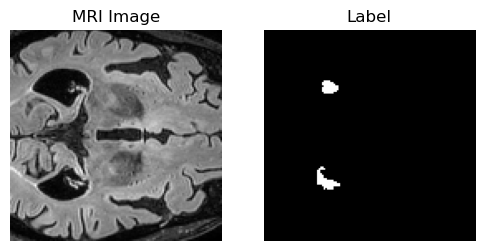

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/6/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/6/mask.nii


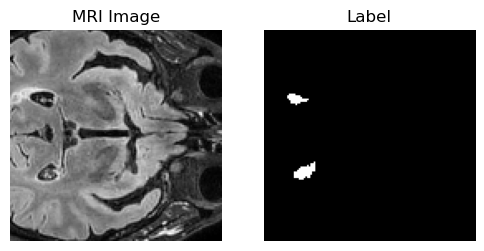

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/17/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/17/mask.nii


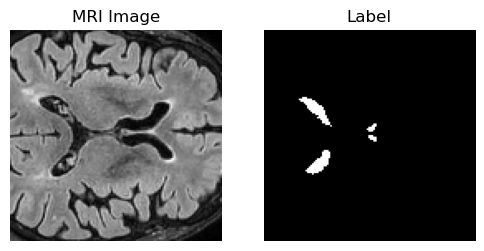

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/1/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/1/mask.nii


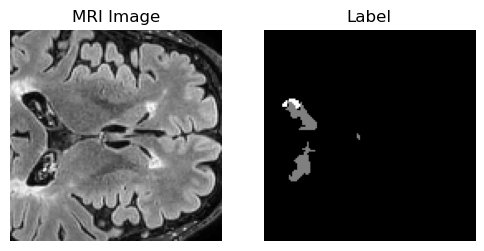

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/10/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/10/mask.nii


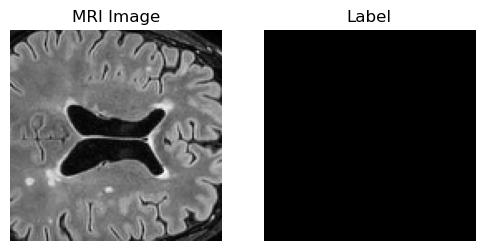

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/19/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/19/mask.nii


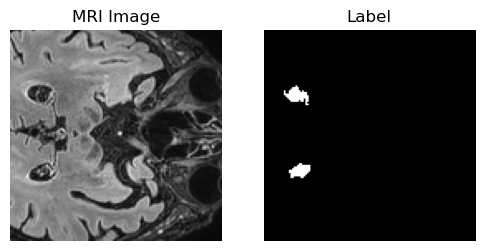

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/8/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/8/mask.nii


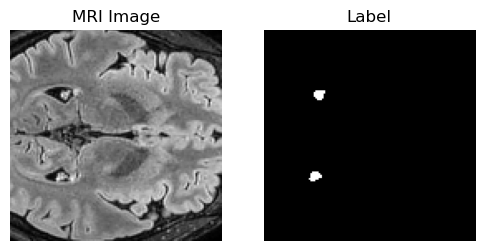

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/4/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/4/mask.nii


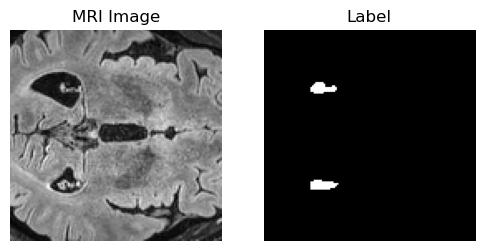

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/15/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/15/mask.nii


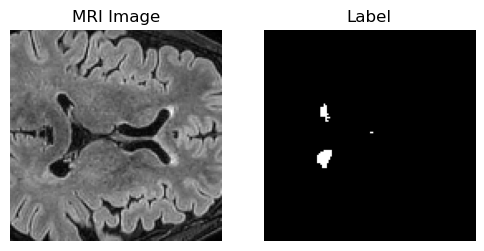

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/3/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/3/mask.nii


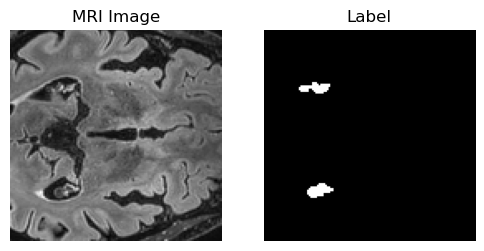

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/12/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/12/mask.nii


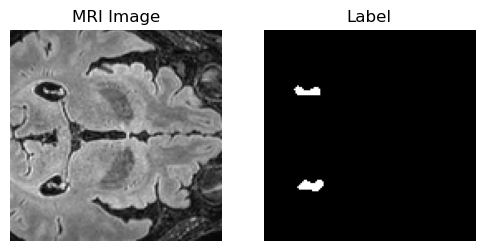

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/2/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/2/mask.nii


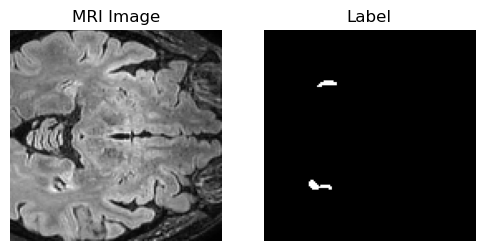

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/13/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/13/mask.nii


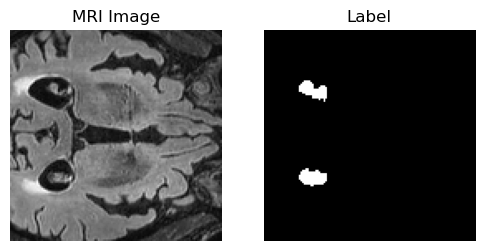

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/5/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/5/mask.nii


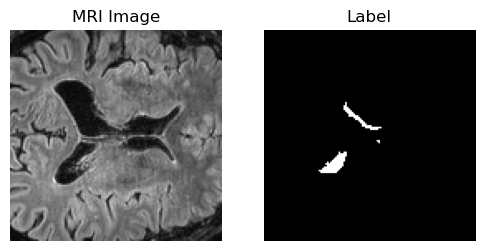

/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/14/co_FLAIR.nii /Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/14/mask.nii


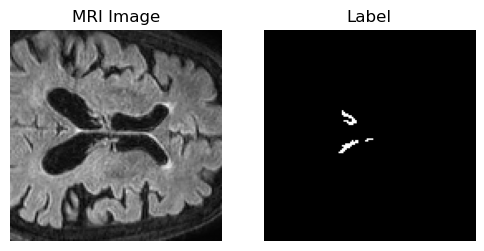

In [50]:
subject_folder="/var/data/MONAI_Choroid_Plexus/ANON_DATA_01_labels/"
subject_folder="/Users/liaschmid/Documents/Uni_Heidelberg/7_Semester_Thesis/phuse_thesis_2024/data/ANON_FLAIR_COREG/"
load_img_and_label_crop_and_display(subject_folder, save_crop=False)
